In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import os
import sys
import torch
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.append("..")

from src.models.unet import UNet
from src.lightning_models.unet_lightning_model import UNetLightningModel
from src.datasets.sky_cover_dataset import SkyCoverModule
from src.config import (
    UNET_CHECKPOINT_PATH,
    DEVICE,
    SEED,
)

In [129]:
# Get model
model = UNet(pretrained=True)
lightning_model = UNetLightningModel.load_from_checkpoint(
    UNET_CHECKPOINT_PATH,
    model=model,
    learning_rate=0,
    weight_decay=0,
    name="unet",
    dataset="sky_finder",
)
model = lightning_model.model.to(DEVICE)
model.eval()
None

In [130]:
module = SkyCoverModule(
    batch_size=1,
    n_workers=1,
    seed=SEED
)
module.setup(stage="fit")
module.setup(stage="test")
train_dataloader = module.train_dataloader()
val_dataloader = module.val_dataloader()
test_dataloader = module.test_dataloader()

🌱 Setting the seed to 0 for generating dataloaders.
🌱 Setting the seed to 0 for generating dataloaders.


In [5]:
it = iter(test_dataloader)

torch.Size([1, 1, 360, 640])


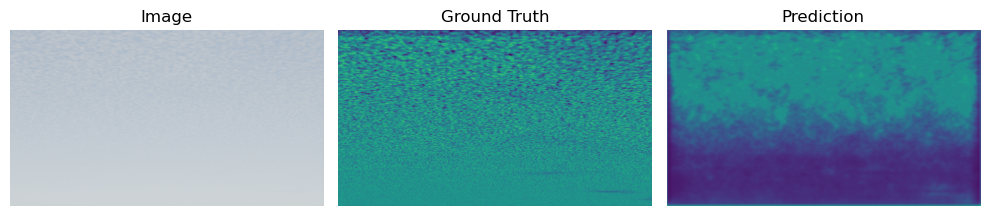

In [164]:
def unnormalize(
        image,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
    image = image.copy()
    image = image * std + mean
    image = image.clip(0, 1)
    return image

batch = next(it)
image = batch[0][0]
ground_truth = batch[1][0]

with torch.no_grad():
    prediction = model(image.unsqueeze(0).to(DEVICE))
    print(prediction.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(unnormalize(image.numpy().transpose(1, 2, 0)))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(ground_truth.numpy().transpose(1, 2, 0), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(prediction[0].cpu().numpy().transpose(1, 2, 0), vmin=0, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()